# Imports

In [1]:
import numpy as np
import pandas as pd
import os

import scipy.io    # Scipy Module that deals with input/output
from skimage.transform import resize   # Image Processing Library
import matplotlib.pyplot as plt
from tqdm import tqdm
import gc    # Garbage Collector
gc.collect()

import os

In [2]:
# Input data files (2015_BOE_Chiu) are available in the "../data/" directory.
print(os.listdir("../data"))

['2015_boe_chiu', 'FashionMNIST', 'mnist_test.csv', 'mnist_test_anom.csv', 'mnist_test_anom_only_8.csv', 'mnist_train.csv']


# Data Preprocessing

In [3]:
# Data Path Setting

input_path = os.path.join('..', 'data', '2015_boe_chiu', '2015_BOE_Chiu')

subject_path = (
    [os.path.join(input_path, 'Subject_0{}.mat'.format(i)) for i in range(1, 10)] +
    [os.path.join(input_path, 'Subject_10.mat')]
)

data_indexes = [10, 15, 20, 25, 28, 30, 32, 35, 40, 45, 50]

width = 284
height = 284
width_out = 196
height_out = 196

In [4]:
subject_path

['..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_01.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_02.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_03.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_04.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_05.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_06.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_07.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_08.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_09.mat',
 '..\\data\\2015_boe_chiu\\2015_BOE_Chiu\\Subject_10.mat']

In [5]:
mat = scipy.io.loadmat(subject_path[0])   # Load Matlab file
img_tensor = mat['images']
manual_fluid_tensor_1 = mat['manualFluid1']

img_array = np.transpose(img_tensor, (2, 0, 1))
manual_fluid_array = np.transpose(manual_fluid_tensor_1, (2, 0, 1))

In [6]:
img_tensor.shape

(496, 768, 61)

In [7]:
img_array.shape

(61, 496, 768)

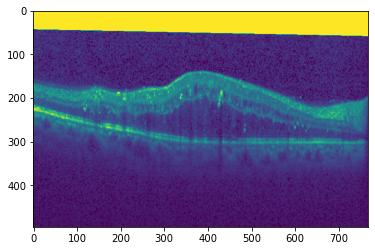

In [8]:
plt.imshow(img_array[25]);

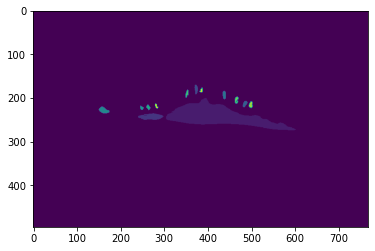

In [9]:
plt.imshow(manual_fluid_array[25]);

In [10]:
# Functions for Data Preprocessing

def thresh(x):
    if x == 0:
        return 0
    else:
        return 1
    
thresh = np.vectorize(thresh, otypes=[float]) 

# otypes = output type
# class numpy.vectorize(pyfunc, otypes=None, doc=None, excluded=None, cache=False, signature=None)

def create_dataset(paths):
    x = []
    y = []
    
    for path in tqdm(paths):
        mat = scipy.io.loadmat(path)
        img_tensor = mat['images']
        fluid_tensor = mat['manualFluid1']
        
        img_array = np.transpose(img_tensor, (2, 0 ,1)) / 255   # Normalization
        img_array = resize(img_array, (img_array.shape[0], width, height))   # Image Resize
        fluid_array = np.transpose(fluid_tensor, (2, 0 ,1))
        fluid_array = thresh(fluid_array)
        fluid_array = resize(fluid_array, (fluid_array .shape[0], width_out, height_out))

        for idx in data_indexes:
            x += [np.expand_dims(img_array[idx], 0)]
            y += [np.expand_dims(fluid_array[idx], 0)]
    return np.array(x), np.array(y)

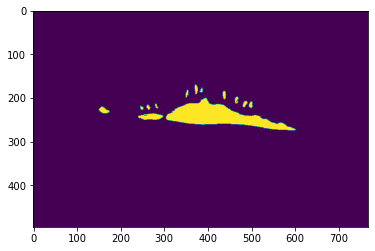

In [11]:
# Demonstration of thresh(x)
plt.imshow(thresh(manual_fluid_array[25]));

# Preparation of Train and Validation Set

In [12]:
x_train, y_train = create_dataset(subject_path[:9])
x_val, y_val = create_dataset(subject_path[9:])

100%|████████████████████████████████████████████████████████████████████████████████████| 1/1 [00:07<00:00,  7.91s/it]


In [13]:
x_train.shape, y_train.shape, x_val.shape, y_val.shape

((99, 1, 284, 284), (99, 1, 196, 196), (11, 1, 284, 284), (11, 1, 196, 196))

# Unet